# Fetch data


## Download imports

In [ ]:
!pip install kagglehub --upgrade
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub
import os
import shutil
import seaborn as sns
import json

## Download tables

In [ ]:
# Download latest version
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")
target_dir = "/content/drive/MyDrive/Bookshelf"
print("Path to dataset files:", path)

source_dir = path
file_names = os.listdir(source_dir)

# get only csv files
csv_files = []
for file_name in file_names:
  if ".csv" in file_name:
    csv_files.append(file_name)

# move them to drive
for file_name in csv_files:
    shutil.move(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/book-recommendation-dataset/versions/3


# Load the data from drive

## Data imports

In [ ]:
import pandas as pd
import numpy as np
import unicodedata
import requests

## Load csv into DataFrame

In [ ]:
books_dtype = {"ISBN" : "string", "Book-Title" : "string", "Book-Author" : "string", "Year-Of-Publication" : "string", "Publisher" : "string", \
               "Image-URL-S": "string", "Image-URL-M": "string", "Image-URL-L": "string"}
df_books = pd.read_csv("/content/drive/MyDrive/Bookshelf/Books.csv", dtype=books_dtype)
df_users = pd.read_csv("/content/drive/MyDrive/Bookshelf/Users.csv")
df_ratings = pd.read_csv("/content/drive/MyDrive/Bookshelf/Ratings.csv")

## Quick look

### Books

### Fix year

* 3 entries with shifted columns



In [ ]:
display(df_books[~df_books['Year-Of-Publication'].str.isdigit()])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,<NA>
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,<NA>
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,<NA>


In [ ]:
books_fix_list = df_books[~df_books['Year-Of-Publication'].str.isdigit()]["ISBN"].copy().values.tolist()
print(books_fix_list)
for wrong_entry in books_fix_list:
  row_list = df_books.loc[df_books['ISBN']==wrong_entry].copy().values.flatten().tolist()

  for idx in range(len(row_list)-1,2,-1):
    row_list[idx]=row_list[idx-1]
    if " " in row_list[idx]:
      row_list[idx] = row_list[idx].strip()

  # split author from title
  parts = row_list[1].split('\\";')
  row_list[1] = parts[0].strip()
  row_list[2] = parts[1].strip('"').replace('ClÃ?Â©zio', 'Clezio')

  #print(row_list)
  df_books.loc[df_books['ISBN']==wrong_entry] = row_list
  display(df_books.loc[df_books['ISBN']==wrong_entry])

['078946697X', '2070426769', '0789466953']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le Clezio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


* drop cover image links

In [ ]:
original_books = df_books.copy()
df_books = df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1)

In [ ]:
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'], downcast='integer')

* dataset was extracted in 2004, any year of publication >2004 is invalid
* dataset has 4618 books that have year of publication 0
* dataset has 72 books that have year of publication > 2004

In [ ]:
year_values = df_books['Year-Of-Publication'].value_counts().sort_index(ascending=True)

In [ ]:
display(year_values.iloc[0])
display(year_values[year_values.index > 2004])
print(year_values[year_values.index > 2004].sum())

4618

,count
Year-Of-Publication,
2005,46
2006,3
2008,1
2010,2
2011,2
2012,1
2020,3
2021,1
2024,1


72


#### api

* api for getting the right years

In [ ]:
request_list_0 = df_books.loc[df_books['Year-Of-Publication']==0]['ISBN'].copy()
request_list_0 = request_list_0.tolist()
#request_list_0 = ['isbn:' + s for s in request_list_0]
request_string_0 = 'isbn:'+'|'.join(request_list_0[:100])
print(request_string_0)
url = "http://openlibrary.org/api/volumes/brief/json/"
headers = {
    "User-Agent": "MyAppName/1.0 (myemail@example.com)"
}
response = requests.get(url+request_string_0, headers=headers)
print(response)

isbn:3150000335|342311360X|0571197639|3596214629|8845229041|0345251733|0590021117|2070362388|2266033689|2070334368|0718144538|0349101779|1860198597|0753804700|3473540420|1566193966|3423009152|0140620338|0571200389|000649840X|0099771519|0552996009|0855030224|1566197155|2070363104|2266000489|0307177092|3518368540|0450542912|0684821192|2253004243|0006550789|0670848549|0330294377|0451117670|8807810360|0553135457|0330312367|2253047422|0340612843|0413588106|0435240765|0753811464|1855853906|076071150X|3423105518|0553130285|0006476333|9721013412|0571069134|1559029838|1857027795|888183152X|0442043244|0571142745|0140051317|0450411435|0752848011|0345283945|0316639842|0349100373|0571154913|0760704767|0590455761|0553142046|1857022424|0733801862|1856273296|0330284142|0861782356|8432021903|0060801115|0553149660|0571135390|1857238982|342310001X|0140250840|0571197272|0140009930|014027944X|0330020706|1856053318|0752521454|0099521016|0330261878|3442435366|3499134411|0340581239|8804379901|8806130684|88171

In [ ]:
req_json = response.json()
print(req_json.keys())
limit = 0
for key, value in req_json.items():
  for key2, value2 in value.items():
      print(value2)
  limit+=1
  if limit >=4:
    break

dict_keys(['isbn:3150000335', '342311360X', '0571197639', '3596214629', '8845229041', '0345251733', '0590021117', '2070362388', '2266033689', '2070334368', '0718144538', '0349101779', '1860198597', '0753804700', '3473540420', '1566193966', '3423009152', '0140620338', '0571200389', '000649840X', '0099771519', '0552996009', '0855030224', '1566197155', '2070363104', '2266000489', '0307177092', '3518368540', '0450542912', '0684821192', '2253004243', '0006550789', '0670848549', '0330294377', '0451117670', '8807810360', '0553135457', '0330312367', '2253047422', '0340612843', '0413588106', '0435240765', '0753811464', '1855853906', '076071150X', '3423105518', '0553130285', '0006476333', '9721013412', '0571069134', '1559029838', '1857027795', '888183152X', '0442043244', '0571142745', '0140051317', '0450411435', '0752848011', '0345283945', '0316639842', '0349100373', '0571154913', '0760704767', '0590455761', '0553142046', '1857022424', '0733801862', '1856273296', '0330284142', '0861782356', '843

#### Simple fix

* copy year column


In [ ]:
df_books['publication_year'] = df_books['Year-Of-Publication'].copy()
df_books = df_books.drop(['Year-Of-Publication'],axis=1)

* replace invalid years with the average

In [ ]:
df_books.loc[(df_books['publication_year'] > 2004) | (df_books['publication_year'] == 0),'publication_year'] = np.NAN
df_books.fillna({'publication_year': round(df_books['publication_year'].mean())}, inplace=True)

In [ ]:
display(df_books.head())
display(df_books.dtypes)
df_books.describe()

,ISBN,Book-Title,Book-Author,Publisher,publication_year
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press,2002
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,2001
2,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial,1991
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Farrar Straus Giroux,1999
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,W. W. Norton &amp; Company,1999


,0
ISBN,string[python]
Book-Title,string[python]
Book-Author,string[python]
Publisher,string[python]
publication_year,Int16


,publication_year
count,271360.0
mean,1993.690496
std,8.247562
min,1376.0
25%,1989.0
50%,1995.0
75%,2000.0
max,2004.0


### Fix publisher

In [ ]:
df_books.loc[df_books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Publisher,publication_year
128890,193169656X,Tyrant Moon,Elaine Corvidae,<NA>,2002
129037,1931696993,Finders Keepers,Linnea Sinclair,<NA>,2001


In [ ]:
display(df_books.loc[df_books['Book-Author']=='Elaine Corvidae',:])
display(df_books.loc[df_books['Book-Author']=='Linnea Sinclair',:])

,ISBN,Book-Title,Book-Author,Publisher,publication_year
126762,1931696934,Winter's Orphans,Elaine Corvidae,Novelbooks,2001
128890,193169656X,Tyrant Moon,Elaine Corvidae,<NA>,2002
129001,0759901880,Wolfkin,Elaine Corvidae,Hard Shell Word Factory,2001


,ISBN,Book-Title,Book-Author,Publisher,publication_year
129037,1931696993,Finders Keepers,Linnea Sinclair,<NA>,2001


* 2 entries with unknown author

In [ ]:
df_books.loc[df_books['Book-Author']=='Elaine Corvidae','Publisher'] = 'unknown'
df_books.loc[df_books['Book-Author']=='Linnea Sinclair','Publisher'] = 'unknown'

### Users

In [ ]:
display(df_users.head())
display(df_users.info())
df_users.describe()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


None

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


### Users age fix
* kids age < 5 don't really read
* only a few people older than 90
* replace them with the mean value for age

In [ ]:
original_users = df_users.copy()
df_users['u_age'] = df_users['Age'].copy()
df_users.loc[(df_users['u_age'] > 90) | (df_users['u_age'] < 5), 'u_age'] = np.NAN
#df_users.fillna({'u_age': round(df_users['u_age'].mean())}, inplace=True)
#df_users['u_age'] = df_users['u_age'].astype(np.int32)

,u_age,count
0,5.0,26
1,6.0,18
2,7.0,27
3,8.0,54
4,9.0,62
...,...,...
81,86.0,7
82,87.0,6
83,88.0,2
84,89.0,2


<Axes: >

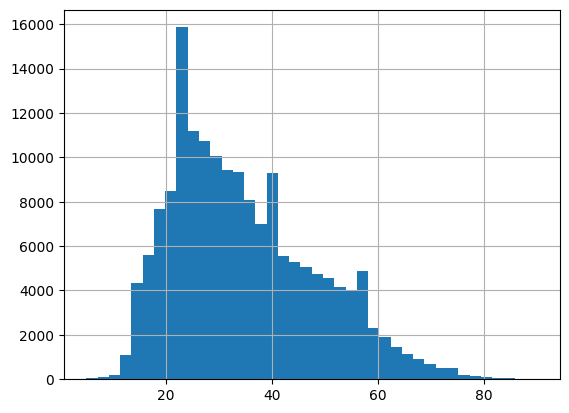

In [ ]:
age_groups = df_users.groupby('u_age')['User-ID'].count().reset_index(name='count')
display(age_groups)
df_users['u_age'].hist(bins=40)

In [ ]:
df_users.fillna({'u_age': round(df_users['u_age'].mean())}, inplace=True)
df_users['u_age'] = df_users['u_age'].astype(np.int32)

* boxenplot for the distribution based on the quartiles

<Axes: ylabel='u_age'>

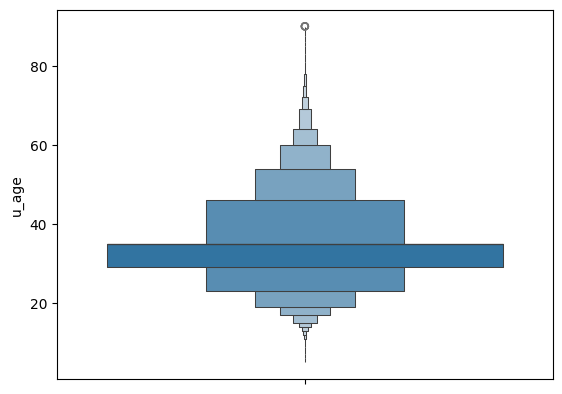

In [ ]:
sns.boxenplot(df_users['u_age'])

### Ratings

In [ ]:
display(df_ratings.head())
display(df_ratings.info())
df_ratings.describe()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


None

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


* For a rating to be valid: needs a book to be rated by an user

In [ ]:
print('Ratings from users not present in the dataset')
display(df_ratings.loc[~(df_ratings['User-ID'].isin(df_users['User-ID']))].size)

Ratings from users not present in the dataset


0

In [ ]:
print('Ratings for books not present in the dataset')
df_ratings[~df_ratings['ISBN'].isin(df_books['ISBN'])]['User-ID'].size

Ratings for books not present in the dataset


118644

* exclude ratings for books that are not present

In [ ]:
df_ratings = df_ratings[df_ratings['ISBN'].isin(df_books['ISBN'])]

In [ ]:
display(df_ratings.info())
df_ratings.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1031136 entries, 0 to 1149778
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1031136 non-null  int64 
 1   ISBN         1031136 non-null  object
 2   Book-Rating  1031136 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 31.5+ MB


None

,User-ID,Book-Rating
count,1.031136e+06,1.031136e+06
mean,1.405945e+05,2.839051e+00
std,8.052466e+04,3.854157e+00
min,2.000000e+00,0.000000e+00
25%,7.041500e+04,0.000000e+00
50%,1.412100e+05,0.000000e+00
75%,2.114260e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


Visualize distribution of reviews

In [ ]:
implicit_no = df_ratings[df_ratings['Book-Rating']==0]['User-ID'].size
explicit_no = df_ratings[df_ratings['Book-Rating']!=0]['User-ID'].size
all_no = df_ratings['User-ID'].size
print('Implicit ratings: ')
print(implicit_no)
print(round((implicit_no/all_no * 100),2))
print('Explicit ratings ')
print(explicit_no)
print(round((explicit_no/all_no * 100),2))

Implicit ratings: 
647294
62.77
Explicit ratings 
383842
37.23


* treat implicit ratings by counts and mean




In [ ]:
df_ratings['new_rating'] = df_ratings['Book-Rating'].copy()
df_ratings['new_rating'] = df_ratings['new_rating'].replace(0, np.NAN)

temp_frame = pd.DataFrame(df_ratings.loc[df_ratings['Book-Rating'] == 0, ['ISBN','new_rating']])

grouped_means = pd.DataFrame(df_ratings.loc[df_ratings['ISBN'].isin(temp_frame['ISBN']),['ISBN','new_rating']].dropna().groupby('ISBN').mean().reset_index())
df_ratings = pd.merge(df_ratings, grouped_means, on='ISBN', how='left')
df_ratings['new_rating_x'] = df_ratings['new_rating_x'].fillna(df_ratings['new_rating_y'])
display(df_ratings)

df_ratings = df_ratings.drop(['new_rating_y'],axis=1)
df_ratings = df_ratings.rename(columns={"new_rating_x": "new_rating"})
df_ratings['new_rating'] = df_ratings['new_rating'].fillna(df_ratings['new_rating'].mean())
df_ratings['new_rating'] = df_ratings['new_rating'].round()
df_ratings['new_rating'] = df_ratings['new_rating'].astype(np.int32)


,User-ID,ISBN,Book-Rating,new_rating
0,276725,034545104X,0,6
1,276726,0155061224,5,5
2,276727,0446520802,0,8
3,276729,052165615X,3,3
4,276729,0521795028,6,6
...,...,...,...,...
1031131,276704,0876044011,0,8
1031132,276704,1563526298,9,9
1031133,276706,0679447156,0,8
1031134,276709,0515107662,10,10


dsada

<Axes: xlabel='new_rating', ylabel='count'>

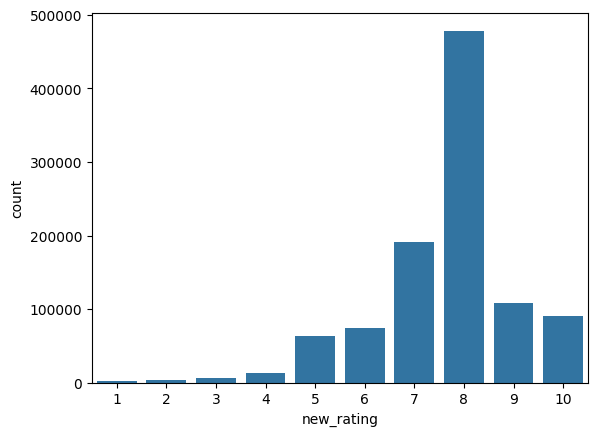

In [ ]:
ratings_grp = df_ratings.groupby('new_rating')['User-ID'].count().reset_index(name='count')
sns.barplot(data=ratings_grp, x='new_rating', y='count')

# Reccomendations based on age

* age groups:
, , , , 60+

1.   5-14
2.   14-18
3.   18-40
4.   40-60
6.   60+




In [ ]:
df_users.loc[df_users['u_age'].between(5,14), 'age_group'] = 1
df_users.loc[df_users['u_age'].between(15,18), 'age_group'] = 2
df_users.loc[df_users['u_age'].between(19,40), 'age_group'] = 3
df_users.loc[df_users['u_age'].between(41,60), 'age_group'] = 4
df_users.loc[df_users['u_age']>60, 'age_group'] = 5

plot_grps = df_users.groupby('age_group')['User-ID'].count().reset_index(name='count')
sns.barplot(data=plot_grps, x='age_group', y='count')

,User-ID,Location,Age,u_age,age_group
0,1,"nyc, new york, usa",NaN,35,3.0
1,2,"stockton, california, usa",18.0,18,2.0
2,3,"moscow, yukon territory, russia",NaN,35,3.0
3,4,"porto, v.n.gaia, portugal",17.0,17,2.0
4,5,"farnborough, hants, united kingdom",NaN,35,3.0
...,...,...,...,...,...
278853,278854,"portland, oregon, usa",NaN,35,3.0
278854,278855,"tacoma, washington, united kingdom",50.0,50,4.0
278855,278856,"brampton, ontario, canada",NaN,35,3.0
278856,278857,"knoxville, tennessee, usa",NaN,35,3.0


* add age groups to reviews

<Axes: xlabel='age_group', ylabel='count'>

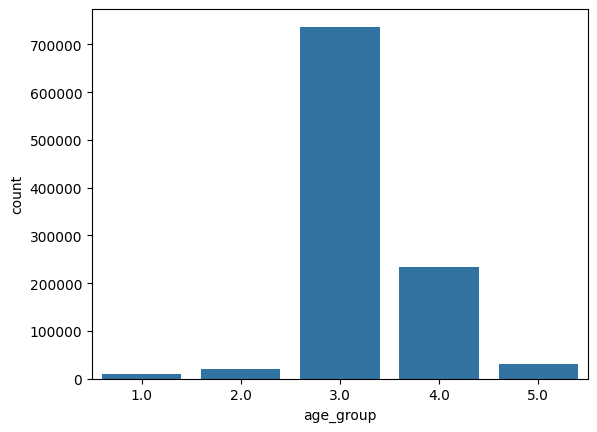

In [ ]:
merging_reviews = pd.merge(df_ratings, df_users[['User-ID','age_group']], on='User-ID')
plot_grps_rev = merging_reviews.groupby('age_group')['User-ID'].count().reset_index(name='count')
sns.barplot(data=plot_grps_rev, x='age_group', y='count')

* best reviewed 20 books by age group (reviews from same agegroup)

In [198]:
grp1 = merging_reviews.loc[merging_reviews['age_group']==1, :]
grp2 = merging_reviews.loc[merging_reviews['age_group']==2, :]
grp3 = merging_reviews.loc[merging_reviews['age_group']==3, :]
grp4 = merging_reviews.loc[merging_reviews['age_group']==4, :]
grp5 = merging_reviews.loc[merging_reviews['age_group']==5, :]

max_g1 = grp1.groupby('ISBN')['new_rating'].agg(mean='mean',count='count').reset_index()
max_g1['performance']= max_g1['count']*max_g1['mean']
max_g1 = max_g1.sort_values(by='performance',ascending=False)
top20_1 = grp1.groupby('ISBN')['new_rating'].count().sort_values(ascending=False)

In [199]:
display(max_g1)

,ISBN,mean,count,performance
6560,0971880107,4.487805,41,184.0
4008,059035342X,9.235294,17,157.0
2093,0439064872,9.272727,11,102.0
326,0064407667,9.400000,10,94.0
2316,043935806X,9.200000,10,92.0
...,...,...,...,...
2233,0439217512,1.000000,1,1.0
7051,3423706783,1.000000,1,1.0
7121,357020720X,1.000000,1,1.0
644,0141302038,1.000000,1,1.0


In [200]:
display(max_g1.head(20))

,ISBN,mean,count,performance
6560,0971880107,4.487805,41,184.0
4008,059035342X,9.235294,17,157.0
2093,0439064872,9.272727,11,102.0
326,0064407667,9.400000,10,94.0
2316,043935806X,9.200000,10,92.0
2762,0440998050,8.777778,9,79.0
4281,0590453653,8.555556,9,77.0
2647,0440414806,9.250000,8,74.0
5857,0786817070,9.000000,8,72.0
2077,0439049962,7.666667,9,69.0


# CATEGORIES

In [ ]:
isbn_list = df_books['ISBN'].tolist()
print(len(isbn_list))
responses = {}
url = "https://www.googleapis.com/books/v1/volumes?q="
for idx in range(0,10000):
  responses[isbn_list[idx]] = (requests.get(url+isbn_list[idx]+"+isbn", headers={})).json()
pd.DataFrame(responses)
json_object = json.dumps(responses, indent=4)
with open("/content/drive/MyDrive/Bookshelf/responses.json", "w") as outfile:
    outfile.write(json_object)


In [ ]:
with open('/content/drive/MyDrive/Bookshelf/responses.json', 'r') as openfile:

    # Reading from json file
    json_object = json.load(openfile)

# Assumptions

Interaction: An user bought a book from our shop. <br>
An interaction -> an entry in the reviews table
* **(== 0)** the reader didn't left a review, possible assumptions: <br>
  the reader forgot to leave a review <br>
  the reading experience was mediocre (the reader didn't get the drive to leave a review)
* **(!= 0)** the reader left a review: <br>
  **<= 5** bad impression <br>
  **> 5** good impression




# Proposed solution

User independent recommendation by category
Get the categories for all our books from the api
Calculate average rating for each category
For new users: reccomend (3-5) books from top categories
For existing users: filter their 3 top categories and reccomend 3-5 books from there which he did not read